# Ley del semicirculo de Wigner

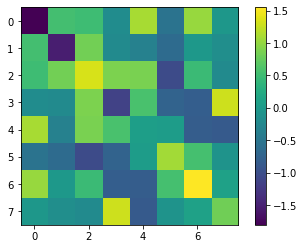

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

#funcion de densidad (semicirculo de Wigner)
def density_func(x,dim):
    return((2/((np.pi)*(2*dim)))*np.sqrt(2*dim-(x**2)))
    
#funcion pa generar la distribucion espectral
def spec_dist(n_sets,dim):
    n_x=[]
    for ii in range(n_sets):
        A = np.random.randn(dim,dim)
        A = (A+np.transpose(A))/2
        for jj in range(dim):
            n_x.append(np.linalg.eigvals(A)[jj])
    return(n_x)

M=np.random.randn(8,8)
plt.imshow((M+np.transpose(M))/2)
plt.colorbar()

# Para muchas matrices pequeñas 


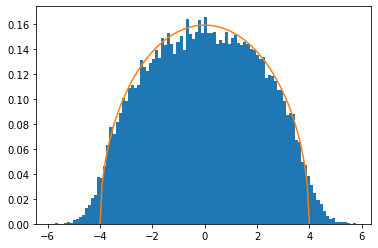

In [2]:
plt.hist(spec_dist(5000,8),100, density=True)
plt.plot(np.linspace(-4,4,100),density_func(np.linspace(-4,4,100),8))

In [3]:
#Se tienen los limites espectrales en:

print([-np.sqrt(2*8),np.sqrt(2*8)])

[-4.0, 4.0]


# Para matrices grandes


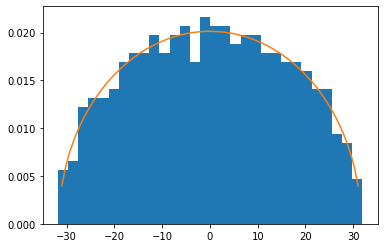

In [4]:
plt.hist(spec_dist(1,500),30,density=True)
plt.plot(np.linspace(-31,31,100),density_func(np.linspace(-31,31,100),500))

In [5]:
#Se tienen los limites espectrales en:

print([-np.sqrt(2*500),np.sqrt(2*500)])

[-31.622776601683793, 31.622776601683793]


# Marchenko-Pastur Density

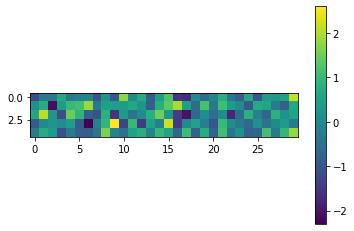

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def cv(a):
    #para definir la matriz de covarianza
    return np.matmul(a, a.transpose())/a.shape[1]

a1=np.random.normal(size=(5,30))

plt.imshow(a1)
plt.colorbar()

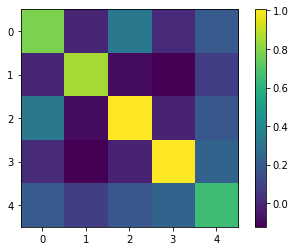

In [2]:
plt.imshow(cv(a1))
plt.colorbar()

In [3]:
#los eigenvalores
ee, ev=np.linalg.eigh(cv(a1))
ee

array([0.41171011, 0.53571057, 0.88957784, 1.08656436, 1.37882965])

In [4]:
def marchpast(l, g):
    "Distribucion Marchenko-Pastur"
    def m0(a):
        "Maximo en (a,0)"
        return np.maximum(a, np.zeros_like(a))
    gplus  = (1+g**0.5)**2
    gminus = (1-g**0.5)**2
    return np.sqrt( m0(gplus-l)*m0(l-gminus) ) / (2*np.pi*g*l)

def randcv(n, p, s):
    """
    funcion para crear varias matrices de covarianza
    s matrices de covarianza creadas con matrices de forma n x p 
    Da un arreglo de dimensiones  s x n x n
    """
    r=[]
    for i in range(s):
        x=np.random.normal(size=(n,p))
        r.append(cv(x))
    return np.array(r)

def EE(a, gamma):
    "Funcion pa los histogramas"
    ee, ev=np.linalg.eigh(a)
    nn, bb, patches=plt.hist(ee.ravel(), 
                                bins="auto", 
                                density=True)
    x=np.arange(bb[0], bb[-1], 0.003)
    plt.plot(x, marchpast(x, gamma))
    plt.ylim(top=nn[1:].max() * 1.1)
    plt.show()

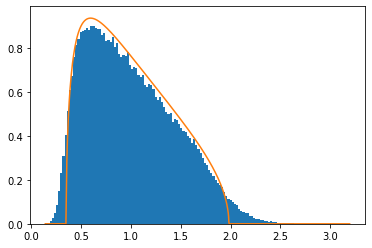

In [26]:
#con matrices chicas de 5 x 30

EE(randcv(5,30,50000), 5.0/30.)

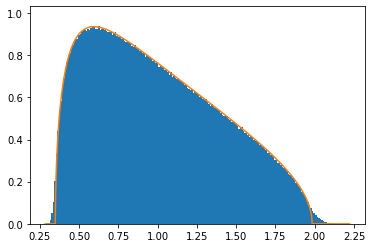

In [11]:
#con matrices grandes de 50 x 300 empieza a converger mejor

EE(randcv(50,300,50000), 5.0/30.)


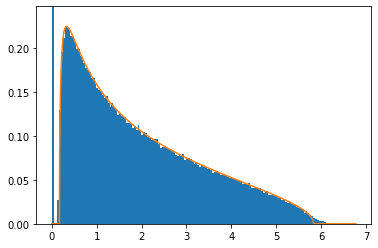

In [12]:
#con una lambda mayor a 1, hay muchos eigenvalores iguales a cero
EE(randcv(100,50,5000), 10./5)


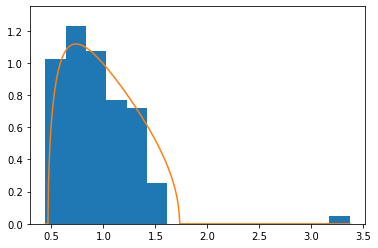

In [8]:
#prueba para separar ruido
kk=[]
for ii in range(1):
    s = np.random.randn(100,1000)
    s = np.matmul(s,s.T)/s.shape[1]
    s = 0.9*s+0.1*(np.matmul(np.random.rand(100,1000),np.random.rand(100,1000).T))/1000
    kk.append(s)
    
EE(kk, 1./10.)
#EE(randcv(5,30,5000), 5.0/30.)

# Encontrar ruido (sacado de https://medium.com/swlh/an-empirical-view-of-marchenko-pastur-theorem-1f564af5603d)

In [16]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity


def mpPDF(var, q, pts):
    """
    Creates a Marchenko-Pastur Probability Density Function
    Args:
        var (float): Variance
        q (float): T/N where T is the number of rows and N the number of columns
        pts (int): Number of points used to construct the PDF
    Returns:
        pd.Series: Marchenko-Pastur PDF
    """
    # Marchenko-Pastur pdf
    # q=T/N
    # Adjusting code to work with 1 dimension arrays
    if isinstance(var, np.ndarray):
        if var.shape == (1,):
            var = var[0]
    eMin, eMax = var * (1 - (1. / q) ** .5) ** 2, var * (1 + (1. / q) ** .5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** .5
    pdf = pd.Series(pdf, index=eVal)
    return pdf

def getPCA(matrix):
    """
    Gets the Eigenvalues and Eigenvector values from a Hermitian Matrix
    Args:
        matrix pd.DataFrame: Correlation matrix
    Returns:
         (tuple): tuple containing:
            np.ndarray: Eigenvalues of correlation matrix
            np.ndarray: Eigenvectors of correlation matrix
    """
    # Get eVal,eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

In [17]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    """
    Fit kernel to a series of obs, and derive the prob of obs x is the array of values
        on which the fit KDE will be evaluated. It is the empirical PDF
    Args:
        obs (np.ndarray): observations to fit. Commonly is the diagonal of Eigenvalues
        bWidth (float): The bandwidth of the kernel. Default is .25
        kernel (str): The kernel to use. Valid kernels are [‘gaussian’|’tophat’|
            ’epanechnikov’|’exponential’|’linear’|’cosine’] Default is ‘gaussian’.
        x (np.ndarray): x is the array of values on which the fit KDE will be evaluated
    Returns:
        pd.Series: Empirical PDF
    """
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    pdf = pd.Series(np.exp(logProb), index=x.flatten())
    return pdf

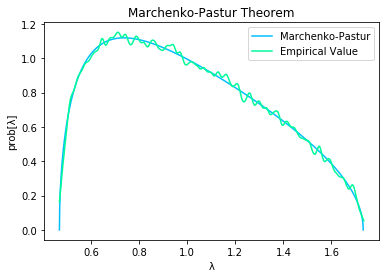

In [18]:
# Generating a random matrix
x = np.random.normal(size=(10000,1000))
# Getting eigenvalues and eigenvectors
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
# Marchenko-Pastur pdf
pdf0 = mpPDF(1., q=x.shape[0]/float(x.shape[1]), pts=1000)
# Empirical pdf
pdf1= fitKDE(np.diag(eVal0), bWidth=0.01)

# Plotting results
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue")
pdf1.plot(label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")

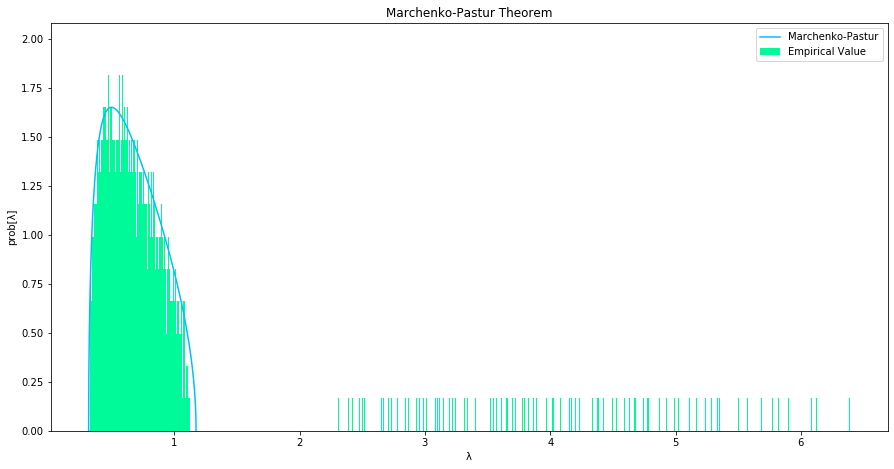

In [19]:
def getRndCov(nCols, nFacts):
    """
    Generates a Random Covariance Matrix
    Args:
        nCols (int): number of columns of random normal. This will be the dimensions of
            the output
        nFacts (int): number of rows of random normal
    Returns:
        np.ndarray: random covariance matrix
    """
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank cov
    return cov


def cov2corr(cov):
    """
    Derive the correlation matrix from a covariance matrix
    Args:
        cov (np.ndarray): covariance matrix
    Returns:
        np.ndarray: correlation matrix
    """
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr


def errPDFs(var, eVal, q, bWidth, pts=1000):
    """
    Fit error of Empirical PDF (uses Marchenko-Pastur PDF)
    Args:
        var (float): Variance
        eVal (np.ndarray): Eigenvalues to fit.
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
        pts (int): Number of points used to construct the PDF
    Returns:
        float: sum squared error
    """
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse


def findMaxEval(eVal, q, bWidth):
    """
    Find max random eVal by fitting Marchenko’s dist (i.e) everything else larger than
        this, is a signal eigenvalue
    Args:
        eVal (np.ndarray): Eigenvalues to fit on errPDFs
        q (float): T/N where T is the number of rows and N the number of columns
        bWidth (float): The bandwidth of the kernel.
    Returns:
         (tuple): tuple containing:
            float: Maximum random eigenvalue
            float: Variance attributed to noise (1-result) is one way to measure
                signal-to-noise
    """

    out = minimize(lambda *x: errPDFs(*x), .5, args=(eVal, q, bWidth),
                   bounds=((1E-5, 1 - 1E-5),))
    if out['success']:
        var = out['x'][0]
    else:
        var = 1
    eMax = var * (1 + (1. / q) ** .5) ** 2
    return eMax, var
  
alpha, nCols, nFact, q = .995, 1000, 100, 10
# Random Matrix
rand_matrix = np.random.normal(size=(nCols * q, nCols))
# Covariance Matrix
cov = np.cov(rand_matrix, rowvar=0)
# Adding signal to Covariance Matrix
cov = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact) # noise + signal
# Converting Covariancce to Correlation
corr0 = cov2corr(cov)
# Getting Eigenvalues and Eigenvectors
eVal0, eVec0 = getPCA(corr0)

# Getting Max Eigenvalues and calculating variance attributed to noise
eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

# Getting PDFs and plotting it
pdf0 = mpPDF(var0, q=10, pts=1000)
pdf1 = fitKDE(np.diag(eVal0), bWidth=0.01)  # Empirical PDF

# Plotting PDFs
ax = pdf0.plot(title="Marchenko-Pastur Theorem", label="Marchenko-Pastur", color="deepskyblue", figsize=(15,7.5))
ax.hist(pd.Series(np.diag(eVal0)), density="norm", bins=1000, label="Empirical Value", color="mediumspringgreen")
ax.set(xlabel="λ", ylabel="prob[λ]")
ax.legend(loc="upper right")
